<a href="https://colab.research.google.com/github/bchada/.github/blob/main/PredictKAM_Lab_Day2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Predict Peak Knee Adduction Moment (KAM) from Marker Positions: In-Class Lab

> Running Inverse kinematics and dynamics can require large computations and time. What if we instead train a machine learning model to take key points (or marker positions) and directly compute KAM?

In this lab you'll:
1. **Explore the dataset** (marker trajectories and peak KAM).
2. Learn to make DataLoaders and training loops
3. Build and train a **simple linear layer** from flattened marker positions to peak KAM.
4. Build a **Multilayer Perceptron (MLP)** and  **Long Short-term Memory (LSTM)**.
6. Mix and match to try to outperform a linear regression!

Data descriptions and original pipeline (keras) are in the project README and paper (see course site). This lab is adapted for educational purposes.


In [1]:
# !pip -q install numpy torch torchvision torchaudio scikit-learn matplotlib

import os, sys, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib as mpl

# Colab display defaults
%matplotlib inline
plt.rcParams['figure.dpi'] = 120
mpl.rcParams['animation.html'] = 'jshtml'

# Reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

g = torch.Generator().manual_seed(42)
set_seed(42)

print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())


Torch: 2.8.0+cu126 | CUDA available: False


In [2]:
from google.colab import drive
import zipfile, os

drive.mount('/content/drive', force_remount=True)

# Change this to your repo/folder containing utils.py
PROJECT_DIR = "/content/drive/MyDrive/Simulations_ML_Lab"
assert os.path.exists(os.path.join(PROJECT_DIR, "utils.py")), "utils.py not found at PROJECT_DIR"

# Add to Python path so "from utils import ..." works
if PROJECT_DIR not in sys.path:
    sys.path.append(PROJECT_DIR)

from utils import scatter_pred_vs_true, show_marker_positions, PlotTrainingCurves, sample_indices_per_subject

zip_path = os.path.join(PROJECT_DIR, "inputData.zip")
extract_path = os.path.join(PROJECT_DIR, "Data")
data_file = os.path.join(extract_path, "inputData.npy")

# Make sure the target folder exists
os.makedirs(extract_path, exist_ok=True)

# Only extract if inputData.npy not already there
if not os.path.exists(data_file):
    print("inputData.npy not found — extracting archive...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
else:
    print("inputData.npy already exists, skipping extraction.")

# List contents for verification
print("Contents of Data folder:", os.listdir(extract_path))



Mounted at /content/drive
inputData.npy already exists, skipping extraction.
Contents of Data folder: ['inputData.npy', 'subjectSplit.npy']



## 1) Load & Explore the Data

The dataset provides **marker trajectories** (13 markers (x, y, z) × 30 timesteps per step), **KAM** during stance, and other metadata (described in README).  
First lets load and explore the dataset.


In [3]:
# Load input data dictionary
DATA_FILE = os.path.join(PROJECT_DIR, "Data/inputData.npy")
inputData = np.load(DATA_FILE, allow_pickle=True).flat[0]

# Marker Positions
markerPos = inputData["markers"]

# Height (per step)
height = inputData["height"]

# Weight (per step)
weight = inputData["weight"]

# Leg (per step)
leg = inputData["leg"]

# Subject Number (per step)
subind = inputData["subjectStepInds"]

# First Knee Adduction Moment Peak (per step)
KAM = inputData["KAM"]

# Visualizing the marker data
participant = 0 # try 0-85
show_marker_positions(inputData, participant=participant, frame_idx=0) # frame_idx options are 0-29



We should normalize marker positions by height and KAM by BW*h to reduce inter-subject size effects.

When training your models, see if you can reduce the number of inputs (features) before training.
1. Since we are only concerned with the first half of stance, extract the peak KAM up to frame 15 as our target.
2. Then we only need the frames 0-15 of marker positions.
3. We can also downsample the first half, so we only have 8 timepoints for each marker.
4. During training, the model has to learn both right and left leg stance, so lets help it out by including a leg index.

Input shape is (112730, 8, 40)
Output shape is (112730, 1, 1)


Text(0.5, 0, 'Step')

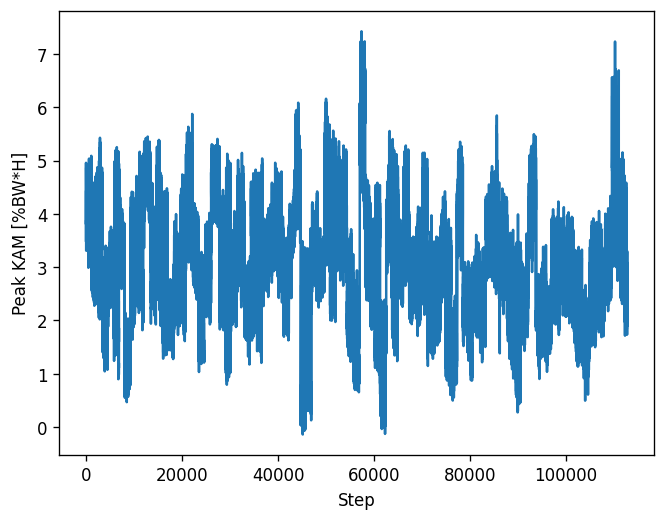

In [4]:
# Adjust input to correct format
markers = np.moveaxis(markerPos, [0,1,2], [2,1,0]) # nSamples x nTimesteps x nFeatures
weightMat = np.expand_dims(weight,axis=2)
heightMat = np.expand_dims(height,axis=2)
legBin = np.expand_dims(leg,axis=2)

# Normalize positions by height
markersNorm = np.divide(markers,heightMat)
inputMat = np.concatenate((markersNorm, legBin),axis = 2) # add leg to markers

# Use positions from first half of stance only, downsampled to 8 timepoints
firstHalfStance = range(0,16,2)
inputMat = inputMat[:,firstHalfStance,:] # nSamples x nTimesteps x nFeatures
print("Input shape is " + str(inputMat.shape))

# Reshape the output
KAMreshape = KAM.reshape((-1,30,1))

# Normalize KAM data by height and weight (gives units of BW*H)
KAMnorm = np.divide(KAMreshape,np.multiply(weightMat.reshape(-1,30,1),heightMat.reshape(-1,30,1))) * 100

# Find peak KAM
KAMP1 = np.max(KAMnorm[:,range(15),:],axis=1)
output = KAMP1.reshape((-1,1,1))
print("Output shape is " + str(output.shape))

plt.plot(output[:,0,0])
plt.ylabel("Peak KAM [%BW*H]")
plt.xlabel("Step")


> The subject split should be done prior to training/evaluating to avoid data leakage

We will use the original paper's subject split, which is given in "subjectSplit.npy", so everyone in the class can compare results.

In [5]:
# Load paper's subject split
SUB_SPLIT_PATH = os.path.join(PROJECT_DIR, "Data/subjectSplit.npy")
subFile = np.load(SUB_SPLIT_PATH, allow_pickle=True)
subSplit = subFile.flat[0]
trainNums = subSplit["trainNums"]
devNums = subSplit["devNums"]
testNums = subSplit["testNums"]

# # Find step indicies for each subject in each set
# trainInds = np.array(0)
# for i in trainNums:
#     trainInds = np.append(trainInds,np.argwhere(subind==i))
# trainInds = trainInds[1:]
#
# devInds = np.array(0)
# for i in devNums:
#     devInds = np.append(devInds,np.argwhere(subind==i))
# devInds = devInds[1:]
#
# testInds = np.array(0)
# for i in testNums:
#     testInds = np.append(testInds,np.argwhere(subind==i))
# testInds = testInds[1:]

MAX_STEPS_PER_SUBJECT = 500

trainInds = sample_indices_per_subject(subind, trainNums, MAX_STEPS_PER_SUBJECT, seed=42)
devInds   = sample_indices_per_subject(subind, devNums,   MAX_STEPS_PER_SUBJECT, seed=42)
testInds  = sample_indices_per_subject(subind, testNums,  MAX_STEPS_PER_SUBJECT, seed=42)


# Build training, development, and test inputs and labels
trainInput_full = inputMat[trainInds,:,:]
trainInput_full = trainInput_full.reshape((trainInput_full.shape[0],-1))
trainLabels = output[trainInds,0]
print("Training shape: " + str(trainInput_full.shape))

devInput_full = inputMat[devInds,:,:]
devInput_full = devInput_full.reshape((devInput_full.shape[0],-1))
devLabels = output[devInds,0]
print("Dev shape: " + str(devInput_full.shape))

testInput_full = inputMat[testInds,:,:]
testInput_full = testInput_full.reshape((testInput_full.shape[0],-1))
testLabels = output[testInds,0]
print("Test shape: " + str(testInput_full.shape))



Training shape: (35000, 320)
Dev shape: (4000, 320)
Test shape: (4000, 320)


> There are additional ways of reducing the features in a model prior to training, such as LASSO.

This is a statistical technique to remove the features which have the smallest impact on the outcome measures.
LASSO was already performed and the indicies are given in "lassoDeletedInds3D".

How many features did this remove?

In [6]:

lassoDeletedInds = inputData["lassoDeletedInds3D"]
inputIndicies = np.delete(np.arange(0,320),np.unique(np.concatenate((np.arange(79,320,40),lassoDeletedInds))))


# Remove input features
trainInput = trainInput_full[:,inputIndicies]
devInput = devInput_full[:,inputIndicies]
testInput = testInput_full[:,inputIndicies]

print("After LASSO: " + str(trainInput.shape))

After LASSO: (35000, 299)


> One of the simplest relationships would be a linear regression from input features to output KAM.

[LinearRegression] Train  R^2: 0.775  |  MAE: 0.368
[LinearRegression] Dev    R^2: 0.492  |  MAE: 0.617


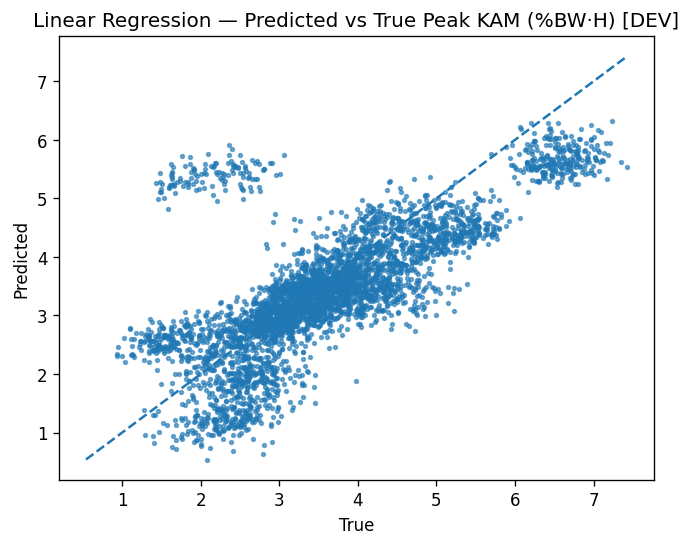

In [7]:
from sklearn.linear_model import LinearRegression

# Fit on TRAIN
linreg = LinearRegression()
linreg.fit(trainInput, np.ravel(trainLabels))  # y must be 1D

# Predict on DEV
train_pred = linreg.predict(trainInput)
dev_pred = linreg.predict(devInput)

# View performance of the training set
train_mae = mean_absolute_error(np.ravel(trainLabels), train_pred)
train_r2  = r2_score(np.ravel(trainLabels), train_pred)
print(f"[LinearRegression] Train  R^2: {train_r2:.3f}  |  MAE: {train_mae:.3f}")

# View performance of the dev set
dev_mae = mean_absolute_error(np.ravel(devLabels), dev_pred)
dev_r2  = r2_score(np.ravel(devLabels), dev_pred)
print(f"[LinearRegression] Dev    R^2: {dev_r2:.3f}  |  MAE: {dev_mae:.3f}")

# Do NOT evaluate on the test set until you have chosen a final model!

# Scatter plot (Predicted vs True on DEV)
scatter_pred_vs_true(
    y_true=np.ravel(devLabels),
    y_pred=dev_pred,
    title="Linear Regression — Predicted vs True Peak KAM (%BW·H) [DEV]"
)

## Day 2) Training and building models

TensorDatasets expect torch.dtype rather than numpy, and use this to make DataLoaders.

The training loader will be used during training, so we want the order shuffled and a generator for repeatability.
For dev and test loaders, do not shuffle, so each evaluation is consistent!

In [8]:
BATCH_SIZE = 256

train_ds = TensorDataset(torch.from_numpy(trainInput).float(), torch.from_numpy(trainLabels).float())
dev_ds   = TensorDataset(torch.from_numpy(devInput).float(),   torch.from_numpy(devLabels).float())
test_ds  = TensorDataset(torch.from_numpy(testInput).float(),  torch.from_numpy(testLabels).float())


train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, generator=g)
dev_loader   = DataLoader(dev_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Writing the training loop for PyTorch can seem daunting, but allows full control over the process making it very powerful!

In [9]:
def train_model(model, optimizer, train_loader, val_loader, epochs=20, device=None):
    if device is None:
        device = next(model.parameters()).device

    model = model.to(device)

    criterion = nn.MSELoss() # TODO: define the loss as the mean square error from torch.nn as nn

    history = {
        'train_loss': [], 'train_r2': [], 'train_mae': [],
        'val_loss':   [], 'val_r2':   [], 'val_mae':   []
    }
    best_state, best_val_r2 = None, -1e9

    for epoch in range(1, epochs + 1):
        # -------- Train --------
        # TODO: set your model to training
        model.train()
        train_loss_sum, train_count = 0.0, 0
        tr_true_list, tr_pred_list = [], []

        for inputs, targets in train_loader:
            # TODO: the inputs and targets must be on the same device as your model
            inputs = inputs.to(device)
            targets = targets.to(device)

            # TODO: send your inputs to your model to get a prediction
            preds = model(inputs)
            # TODO: calculate the error between predictions and targets
            loss = criterion(preds, targets)


            # Zeros optimizer gradients
            optimizer.zero_grad()
            # TODO: call for backpropogation
            loss.backward()
            # TODO: step your optimizer
            optimizer.step()

            # Scaling loss by batch size and saving to track training
            bsz = targets.shape[0]
            train_loss_sum += loss.item() * bsz
            train_count    += bsz

            # collect for train metrics
            tr_true_list.append(targets.detach().cpu().numpy())
            tr_pred_list.append(preds.detach().cpu().numpy())

        # After each epoch, we average training loss and get training predictions
        epoch_train_loss = train_loss_sum / max(train_count, 1)
        tr_true = np.concatenate(tr_true_list).ravel()
        tr_pred = np.concatenate(tr_pred_list).ravel()
        epoch_train_r2  = r2_score(tr_true, tr_pred)
        epoch_train_mae = mean_absolute_error(tr_true, tr_pred)

        # -------- Validate --------
        # TODO: set your model to evaluation mode
        model.eval()
        val_loss_sum, val_count = 0.0, 0
        va_true_list, va_pred_list = [], []

        with torch.no_grad(): # So that gradients are not computed
            for inputs, targets in val_loader:
                inputs  = inputs.to(device)
                targets = targets.to(device)

                # TODO: compute predictions and loss, but you do not need your optimizer or backpropogation!
                preds = model(inputs)
                loss = criterion(preds, targets)

                bsz = targets.shape[0]
                val_loss_sum += loss.item() * bsz # summing your loss and normalizing
                val_count    += bsz

                va_true_list.append(targets.detach().cpu().numpy())
                va_pred_list.append(preds.detach().cpu().numpy())

        epoch_val_loss = val_loss_sum / max(val_count, 1)
        va_true = np.concatenate(va_true_list).ravel()
        va_pred = np.concatenate(va_pred_list).ravel()
        epoch_val_r2  = r2_score(va_true, va_pred) # getting r squared score
        epoch_val_mae = mean_absolute_error(va_true, va_pred)

        # Log
        history['train_loss'].append(epoch_train_loss)
        history['train_r2'].append(epoch_train_r2)
        history['train_mae'].append(epoch_train_mae)
        history['val_loss'].append(epoch_val_loss)
        history['val_r2'].append(epoch_val_r2)
        history['val_mae'].append(epoch_val_mae)

        print(
            f"Epoch {epoch:02d} | "
            f"Train  R2={epoch_train_r2:.3f}, MAE={epoch_train_mae:.4f} | "
            f"Val    R2={epoch_val_r2:.3f}, MAE={epoch_val_mae:.4f}"
        )

    return model, history # TODO: return the trained model and history for tracking! # returns model we trained.

Epoch 01 | Train  R2=-1.442, MAE=1.2277 | Val    R2=-0.347, MAE=1.0605
Epoch 02 | Train  R2=-0.006, MAE=0.8000 | Val    R2=-0.342, MAE=1.0589
Epoch 03 | Train  R2=0.017, MAE=0.7919 | Val    R2=-0.331, MAE=1.0550
Epoch 04 | Train  R2=0.041, MAE=0.7835 | Val    R2=-0.318, MAE=1.0505
Epoch 05 | Train  R2=0.064, MAE=0.7750 | Val    R2=-0.302, MAE=1.0444
Epoch 06 | Train  R2=0.086, MAE=0.7671 | Val    R2=-0.297, MAE=1.0432
Epoch 07 | Train  R2=0.105, MAE=0.7597 | Val    R2=-0.284, MAE=1.0384
Epoch 08 | Train  R2=0.122, MAE=0.7531 | Val    R2=-0.254, MAE=1.0257
Epoch 09 | Train  R2=0.137, MAE=0.7477 | Val    R2=-0.269, MAE=1.0341
Epoch 10 | Train  R2=0.150, MAE=0.7427 | Val    R2=-0.277, MAE=1.0390
Epoch 11 | Train  R2=0.162, MAE=0.7386 | Val    R2=-0.253, MAE=1.0288
Epoch 12 | Train  R2=0.172, MAE=0.7348 | Val    R2=-0.247, MAE=1.0268
Epoch 13 | Train  R2=0.181, MAE=0.7311 | Val    R2=-0.220, MAE=1.0151
Epoch 14 | Train  R2=0.190, MAE=0.7279 | Val    R2=-0.223, MAE=1.0170
Epoch 15 | Train  

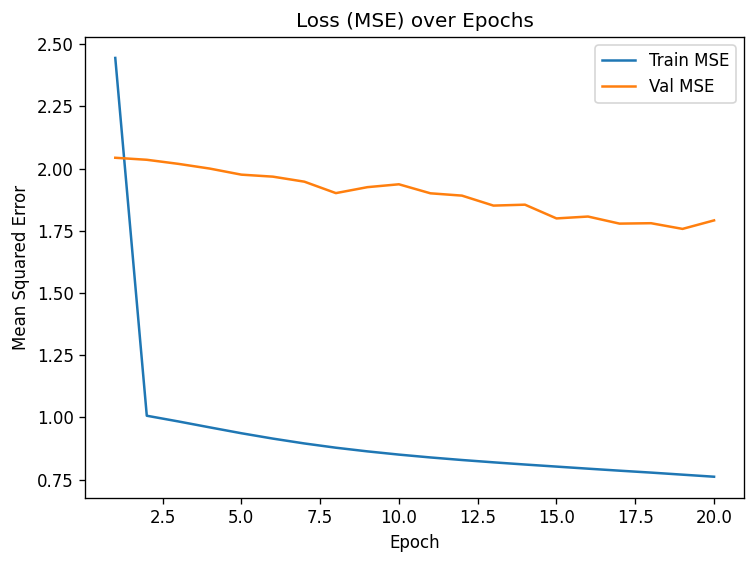

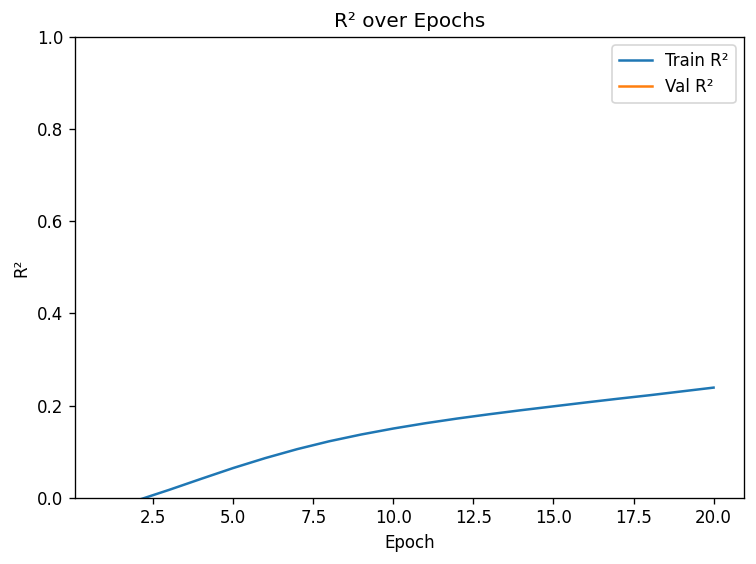

In [24]:
set_seed(42) # This is for repeatability, but brownie points if you know the question for which 42 is the answer :)


class SingleLinear(nn.Module):
    def __init__(self, in_dim):
        super().__init__()

        self.fc = nn.Linear(in_dim, 1)

    def forward(self, x):
        return self.fc(x)


in_dim = trainInput.shape[1]# TODO: get the number of features in your input

lin_model = SingleLinear(in_dim)# TODO: make an instance of the linear model
optimizer = torch.optim.AdamW( lin_model.parameters(), lr=1e-3)
   # TODO: input the model parameters,
   # TODO: set the learning rate to 1e-3



lin_model, history = train_model(lin_model, optimizer, train_loader, dev_loader, epochs=20, device=None)# TODO: Train your model! Look at what the function requires, and what additional options you have!
PlotTrainingCurves(history)

In [ ]:
# make a function to take in any model and evaluate on given set of data
def evaluate_model(model, data_loader):
    # TODO: make sure your model is in evaluation mode!
    with torch.no_grad():
        label_true, label_pred = [], []
        for data, label in data_loader:
            data = data.to(device)
            pred = # TODO: get your predictions, make sure it is on cpu, and numpy
            label_true.append(label.numpy())
            label_pred.append(pred)
    label_true = np.concatenate(label_true).ravel()
    label_pred = np.concatenate(label_pred).ravel()
    return label_true, label_pred

# TODO: evaluate your model on the training and dev sets. Do NOT use the test set yet!

print(f"[Linear] Train R2={r2_score(train_true, train_pred):.3f}, MAE={mean_absolute_error(train_true, train_pred):.4f}")
print(f"[Linear] Dev   R2={r2_score(dev_true, dev_pred):.3f}, MAE={mean_absolute_error(dev_true, dev_pred):.4f}")

# Plot
scatter_pred_vs_true(dev_true, dev_pred, title="Linear — Pred vs True (Dev)")

# Question: a linear layer should perform very similar to the LinearRegression from earlier. Why is this model not performing as well?

> Answer: The learning rate was too low, and the model did not train long enough to converge.

In [ ]:
set_seed(42)

# TODO: Improve the training by changing hyperparameters in the optimizer
lin_model = # TODO: make an instance of the linear model
optimizer = torch.optim.AdamW(
    # TODO: input the model parameters,
    # TODO: set the learning rate to 1e-3
    # TODO: set the weight decay to 1e-4
)
lin_model, history = # TODO: Train your model (We recommend 20 epochs)

PlotTrainingCurves(history)

# Test
train_true, train_pred = evaluate_model(lin_model, train_loader)
dev_true, dev_pred     = evaluate_model(lin_model, dev_loader)

print(f"[Linear] Train R2={r2_score(train_true, train_pred):.3f}, MAE={mean_absolute_error(train_true, train_pred):.4f}")
print(f"[Linear] Dev   R2={r2_score(dev_true, dev_pred):.3f}, MAE={mean_absolute_error(dev_true, dev_pred):.4f}")

# Plot
scatter_pred_vs_true(dev_true, dev_pred, title="Linear — Pred vs True (Dev)")


## Multilayer Perceptron (MLP)

Build a small MLP. Tweak width/depth and observe validation/test performance. You should be able to easily outperform the linear layer.

Note: an MLP is made up of linear layers with activation functions that introduce non-linearity!


In [ ]:
set_seed(42)

class NonLinearRegression(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        # TODO: make 3 Linear layers going from in_dim -> 1024 -> 512 -> 1


        # TODO: Choose an activation function


    def forward(self, x):
        # TODO: Call each linear layer and an activation function between them


        return x


nonLinear_model = # TODO: make an instance of the linear model
optimizer = torch.optim.AdamW(
    # TODO: input the model parameters,
    # TODO: set the learning rate to 1e-3
    # TODO: set the weight decay to 1e-4
)
nonLinear_model, nonLinear_history  = # TODO: Train your model
PlotTrainingCurves(nonLinear_history)



# Question: What is wrong, and how could you improve the training on this model?

> Answer: The model is overfitting. The training loss is decreasing, but the validation loss is increasing. Introduce early stopping and decrease model complexity.